# Data APIs for CAS29

For our CAS29 application prototype, we are currently using APIs from the ACT government to access datasets related to traffic and road safety. Additionally, we use APIs to extract the most recent weather updates from the Bureau of Meteorology (BOM). CAS29 can also be easily adapted to use APIs from the QLD government to access datasets related to traffic and road safety in QLD. 

The purpose of this document is to demonstrate the use case for the data sources listed below in the context of CAS29:

### ACT Data

There are two key historical datasets that we use, both updated daily and going as far back as 2012:
1. Pedestrian Crashes: https://www.data.act.gov.au/Justice-Safety-and-Emergency/Pedestrian-Crashes/emq2-8bc4
2. Cyclist Crashes: https://www.data.act.gov.au/Justice-Safety-and-Emergency/Cyclist-Crashes/n2kg-qkwj

They include geographic co-ordinates of each crash as well as some other details about the severity of the crash, road conditions, time of day etc.

### QLD Data

In QLD, there two key data sources that can be incorporated into CAS29:
1. Road Crash Locations: https://www.data.qld.gov.au/dataset/crash-data-from-queensland-roads
  * Similar to the ACT datasets, this includes the geo-coordinates of the crash sites
  * The data goes back to 2001; however, it only goes up to end-of-2018
  * It is relatively rich in detail
  * Notably, it captures all accident types (including pedestrian and cyclist) in one dataset
    * However, crashes that results in property-damage only are not recorded from 2011 onwards
<br><br>  
2. QLDTraffic GeoJSON API: https://www.data.qld.gov.au/dataset/131940-traffic-and-travel-information-geojson-api
  * This is a real-time information service for the state of QLD
  * It covers the following:
    * Live image feeds from webcams throughout the state
    * Live updates of high-risk crash zones (including geo-coordinates of these zones)
    * Live event updates (e.g. construction) (including geo-coordinates of affected areas)

### BOM Data

We can extract latest available data from relevant weather stations for the cyclist to use. Lists of weather stations are available from the links below:
* ACT: http://www.bom.gov.au/act/observations/canberra.shtml
* QLD: http://www.bom.gov.au/qld/observations/qldall.shtml

Currently, CAS29 only links to the main Canberra weather station, with plans to allow cyclists to access data from their nearest station in future versions.

***

<br><br>
We will use Python to explore each of the above data sources and explain how they are currently used or how they will be used in the future.

In [1]:
#Import Python packages
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import requests
import geopandas as gpd 
from shapely.geometry import Polygon

def get_data(url): 
    """
    Returns JSON responses from URLs
    """
    return requests.get(url).json()

def timeconv(x):
    """
    Converts time form %H:%M format to time in min after midnight
    """
    tmo = time.strptime (x, "%H:%M") 
    return tmo.tm_hour*60+tmo.tm_min

## ACT Historical Crash Data
***
### Pedestrian Crashes
The JSON API output data is a list of records, each structured as a dictionary:

In [2]:
url = 'https://www.data.act.gov.au/resource/emq2-8bc4.json'
act_pc_js = get_data(url)
act_pc_js[0] # first record

{'crash_id': '1152106',
 'crash_date': '2017-01-23T00:00:00.000',
 'crash_time': '16:00',
 'severity': 'Injury',
 'crash_type': 'Struck pedestrian (On Road)',
 'pedestrians': '1',
 'pedestrian_casualties': '1',
 'reported_location': 'RATCLIFFE CRESCENT (CHALLINOR -> CHALLINOR)',
 'location': {'latitude': '-35.23191', 'longitude': '149.054575'}}

These records can be conveniently organised into a DataFrame that CAS29 can access to deliver relevant information to the cyclist:

In [3]:
act_pc = pd.DataFrame(act_pc_js)
act_pc.sample(3)

,crash_id,crash_date,crash_time,severity,crash_type,pedestrians,pedestrian_casualties,reported_location,location
185,1113005,2015-06-04T00:00:00.000,21:20,Injury,Struck pedestrian (On Road),1,1,LAYCOCK PLACE (PICKWORTH -> LAYCOCK),"{'latitude': '-35.222097', 'longitude': '149.0..."
446,1193810,2018-10-04T00:00:00.000,12:46,Property Damage Only,Struck pedestrian (On Road),1,0,SCOTTS CROSSING (NARELLAN -> BUNDA / GAREMA),"{'latitude': '-35.278001', 'longitude': '149.1..."
323,1172898,2017-11-09T00:00:00.000,07:35,Injury,Struck pedestrian (On Road),1,1,SULWOOD DRIVE (LIVINGSTON -> MANNHEIM),"{'latitude': '-35.379904', 'longitude': '149.0..."


We just need to conduct a couple of data cleaning steps so that we have the *latitude* and *longitude* in separate variables, which allows the CAS29 to pinpoint the location of previous crashes to identify high-risk areas:

In [4]:
act_pc['lat'] = act_pc['location'].apply(pd.Series)['latitude']
act_pc['lon'] = act_pc['location'].apply(pd.Series)['longitude']
act_pc['time_in_min'] = act_pc['crash_time'].apply(timeconv) # the CAS2029 app needs to see time in minutes
act_pc = act_pc.astype({'lat':float, 'lon':float}).drop(columns=['location'])
act_pc.sample(3)

,crash_id,crash_date,crash_time,severity,crash_type,pedestrians,pedestrian_casualties,reported_location,lat,lon,time_in_min
181,1135496,2016-05-20T00:00:00.000,17:00,Injury,Struck pedestrian (On Road),1,1,HINDMARSH DRIVE (CALLAM -> BOTANY),-35.348944,149.088871,1020
274,1171421,2017-10-31T00:00:00.000,17:30,Injury,Struck pedestrian (Off Road),1,1,GARTSIDE/MCBRYDE INTERSECTION,-35.405135,149.101108,1050
28,1048754,2012-11-07T00:00:00.000,09:50,Injury,Struck pedestrian (Off Road),1,1,WOLLONGONG STREET (KEMBLA -> GLADSTONE),-35.325404,149.179456,590


### Cyclist Crashes

The API JSON output is very similar to the Pedestrian Crash data above, so we can process it in a similar fashion:

In [5]:
url = 'https://www.data.act.gov.au/resource/n2kg-qkwj.json'
act_cc_js = get_data(url)
act_cc_js[0]

{'crash_id': '1195124',
 'crash_date': '2018-10-31T08:42:00.000',
 'crash_time': '08:42',
 'severity': 'Injury',
 'crash_type': 'Right angle collision',
 'cyclists': '1',
 'cyclist_casualties': '1',
 'reported_location': 'KING GEORGE/LANGTON INTERSECTION',
 'latitude': '-35.300163',
 'longitude': '149.127264',
 'location_1': {'latitude': '-35.300163', 'longitude': '149.127264'},
 ':@computed_region_h8vr_r9vc': '111'}

In [6]:
act_cc = pd.DataFrame(act_cc_js).drop(columns=['location_1', ':@computed_region_h8vr_r9vc'])
act_cc = act_cc.rename(columns={'latitude':'lat', 'longitude':'lon'})
act_cc['time_in_min'] = act_cc['crash_time'].apply(timeconv) # the CAS2029 app needs to see time in minutes
act_cc.sample(3)

,crash_id,crash_date,crash_time,severity,crash_type,cyclists,cyclist_casualties,reported_location,lat,lon,time_in_min
58,1132851,2016-04-06T15:30:00.000,15:30,Injury,Same direction side swipe,1,1,LONDON CIRCUIT (EDINBURGH -> COMMNLONDWRM),-35.28382,149.126355,930
170,1102457,2015-01-18T09:15:00.000,09:15,Injury,Other - Single Vehicle (On Road),1,1,PARKES WAY (ANZAC -> PARKEKINGERM RAMP),-35.291323,149.141077,555
190,1067226,2013-07-29T18:25:00.000,18:25,Injury,Other - Vehicle to Vehicle,1,1,TENISON-WOODS CIRCUIT (BROOKER -> TENISON-WOODS),-35.425403,149.076807,1105


## QLD Historical Crash Data

Since the QLD API for historical crash data has query size limitations, we need to assemble it piece-wise by year.

In the variables below, we can see that we have some similar fields to ACT data:

* `Crash_Hour` identifies the time
* `Crash_Longitude_GDA94` and `Crash_Latitude_GDA94` pinpoint the location
* `Count_Unit_Bicycle` shows whether a cyclist was involved

In [7]:
limit = 32000
df_list = []

for year in range(2000,2019):

    url = 'https://www.data.qld.gov.au/api/3/action/datastore_search?' \
        + 'resource_id=e88943c0-5968-4972-a15f-38e120d72ec0' \
        + '&limit=' + str(limit) \
        + '&q=' + '{"Crash_Year":"'+str(year)+'"}'
    
    qld_rc_js = get_data(url)
    df_list.append(pd.DataFrame(qld_rc_js['result']['records']))
    
qld_rc = pd.concat(df_list, ignore_index=True)

qld_rc.info()    

C:\Users\rober\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328247 entries, 0 to 328246
Data columns (total 52 columns):
Crash_Ref_Number                   328247 non-null int64
Crash_Severity                     328247 non-null object
Crash_Year                         328247 non-null int64
Crash_Month                        328247 non-null object
Crash_Day_Of_Week                  328247 non-null object
Crash_Hour                         328247 non-null int64
Crash_Nature                       328247 non-null object
Crash_Type                         328247 non-null object
Crash_Longitude_GDA94              328247 non-null float64
Crash_Latitude_GDA94               328247 non-null float64
Crash_Street                       328238 non-null object
Crash_Street_Intersecting          141695 non-null object
State_Road_Name                    151727 non-null object
Loc_Suburb                         328247 non-null object
Loc_Local_Government_Area          328247 non-null object
Loc_Post_Code       

There is much more information here relative to ACT counterparts (then again, QLD is a bigger place!), so we need to be selective about the variables we feed into CAS29. Importantly, we should distinguish pedestrian from cyclist crashes as we did for ACT data.

First, let's select a subset of variables similar to the ones we obtain in the ACT:

In [8]:
qld_vars = ['Crash_Ref_Number',
            'Crash_Year',
            'Crash_Month',
            'Crash_Day_Of_Week',
            'Crash_Hour',
            'Crash_Severity',
            'Crash_Type',
            'Count_Casualty_Total',
            'Count_Unit_Pedestrian',
            'Count_Unit_Bicycle',
            'Crash_Street',
            'Crash_Latitude_GDA94',
            'Crash_Longitude_GDA94'             
           ]

### Pedestrian Crashes

Here, we subset crashes that involved pedestrians, and apply some of the steps we did with ACT data:

In [9]:
qld_pc = qld_rc[qld_rc['Count_Unit_Pedestrian']>0][qld_vars]
qld_pc = qld_pc.rename(columns={'Crash_Latitude_GDA94':'lat', 'Crash_Longitude_GDA94':'lon'})
qld_pc['time_in_min'] = qld_pc['Crash_Hour']*60
qld_pc.sample(3)

,Crash_Ref_Number,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Severity,Crash_Type,Count_Casualty_Total,Count_Unit_Pedestrian,Count_Unit_Bicycle,Crash_Street,lat,lon,time_in_min
219842,219843,2008,February,Sunday,9,Hospitalisation,Hit pedestrian,1,1,0,D'Aguilar Hwy,-26.945480,152.565477,540
241509,241510,2016,November,Friday,7,Hospitalisation,Hit pedestrian,1,1,0,Bundaberg - Gin Gin Rd,-24.850864,152.335376,420
174328,174329,2005,April,Saturday,18,Hospitalisation,Hit pedestrian,1,1,0,Ferndale St,-27.517085,153.029827,1080


### Cyclist Crashes

Here, we subset crashes that involved cyclists, and again apply some of the steps we did with ACT data:

In [10]:
qld_cc = qld_rc[qld_rc['Count_Unit_Bicycle']>0][qld_vars]
qld_cc = qld_cc.rename(columns={'Crash_Latitude_GDA94':'lat', 'Crash_Longitude_GDA94':'lon'})
qld_cc['time_in_min'] = qld_cc['Crash_Hour']*60
qld_cc.sample(3)

,Crash_Ref_Number,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Severity,Crash_Type,Count_Casualty_Total,Count_Unit_Pedestrian,Count_Unit_Bicycle,Crash_Street,lat,lon,time_in_min
119458,119459,2010,February,Wednesday,15,Medical treatment,Multi-Vehicle,1,0,1,Brinsmead Rd,-16.893633,145.710570,900
13030,13031,2006,May,Wednesday,8,Minor injury,Multi-Vehicle,1,0,1,Bundaberg - Port Rd,-24.879637,152.350979,480
30414,30415,2015,September,Tuesday,17,Medical treatment,Multi-Vehicle,1,0,1,Rich La,-27.465317,153.029914,1020


## QLD Real-time Traffic Data

This real-time API can be a source of very useful features for CAS29 users in QLD. We explain each feature below.

In [11]:
def make_url(i):
    """
    Takes a value from {0,1,2} to generate the API query for webcams, high-risk crash zones and events respectively
    """
    types = ['v1/webcams','v1/highriskcrashzones','v2/events']
    return 'https://api.qldtraffic.qld.gov.au/' + types[i] \
            + '?apikey=3e83add325cbb69ac4d8e5bf433d770b'

### Webcams

Webcams provide live images from various roads around QLD. 

In [12]:
r = get_data(make_url(0))
r.keys()

dict_keys(['type', 'features', 'published', 'rights'])

Below we see how many webcams we are getting feeds from:

In [13]:
print('We can access live images from '+str(len(r['features']))+' cameras!')

We can access live images from 177 cameras!


Let's see what metadata the first camera gives us. Aside from the `image_url` required to access the feed, we also get location coordinates which can be matched against a cyclist's location or planned route.

In [14]:
r['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [153.0086975, -27.5551796]},
 'properties': {'id': 1,
  'url': 'https://api.qldtraffic.qld.gov.au/v1/webcams/1',
  'description': 'Archerfield - Ipswich Mwy - North',
  'direction': 'NorthEast',
  'district': 'Metropolitan',
  'locality': 'Archerfield',
  'postcode': '4108',
  'image_url': 'https://webcams.qldtraffic.qld.gov.au/Metropolitan/Archerfield_Ipswich_Mwy_sth.jpg',
  'image_sourced_from': None,
  'isCustom': False}}

We can now navigate to the `image_url` and extract the image. CAS29 users in QLD could potentially be able to access image feeds from webcams along a given route to get an idea of traffic conditions or other hazards (e.g. large puddles that may be hard for cyclists to navigate) before setting out on their journey. CAS29 itself may be able to identify hazards from the feeds to alert cyclists about.

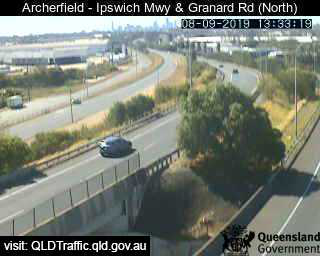

In [15]:
from PIL import Image
from io import BytesIO
img_url = r['features'][0]['properties']['image_url']
r_img = requests.get(img_url)
img = Image.open(BytesIO(r_img.content))
img

### High-risk Crash Zones

We can also extract the most up-to-date high-risk crash zones:

In [16]:
r = get_data(make_url(1))
r.keys()

dict_keys(['name', 'type', 'crs', 'features', 'published', 'rights'])

In [17]:
print('We are looking at the '+ r['name'].replace('_',' ')+ ' high-risk crash zones')

We are looking at the Top 26 high-risk crash zones


Let's take a look at the first zone:
* We can extract its coordinates from `geometry`
* We can get extra information from `properties`

In [18]:
r['features'][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [19]:
zone_coords = r['features'][0]['geometry']['coordinates'][0]
zone_coords[:5]

[[153.304967, -27.650293996],
 [153.305184, -27.649339996],
 [153.305243, -27.649060996],
 [153.305269, -27.648925],
 [153.30529, -27.648796]]

In [20]:
r['features'][0]['properties']

{'road_section_id': '109',
 'road_name': 'Cleveland Redland Bay Road',
 'description': 'This road has experienced a higher crash occurrence in the past compared to other roads. Road Users are advised to take care and to drive to prevailing conditions',
 'Suburb': 'Cleveland / Redland Bay / Thornlands / Victoria Point',
 'District': 'Metropolitan'}

Furthermore, we could plot out the zone (and even overlay it on a local map) using latitude and longitude coordinates. Below is just an outline of the zone:

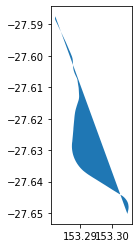

In [21]:
df = gpd.GeoDataFrame(columns=['geometry'])
df = df.append({'geometry': (Polygon(zone_coords))}, ignore_index=True)
df.plot()
plt.show()

### Events

Obtaining information on Events is similar to High-risk crash zones:

In [22]:
r = get_data(make_url(2))
r.keys()

dict_keys(['type', 'features', 'published', 'rights'])

In [23]:
print('There are '+str(len(r['features']))+' events!')

There are 283 events!


Taking a look at the first event, we can perform the same basic analysis as above:

In [24]:
zone_coords = r['features'][0]['geometry']['coordinates'][0]
zone_coords[:5]

[[148.9395348, -21.3292286],
 [148.93963, -21.33001],
 [148.93969, -21.3303],
 [148.94012, -21.33247],
 [148.94039, -21.33365]]

In addition to the coordinates for the area affected by the event, there are also many event details under `properties` that are potentially relevant to a CAS29 user: 

In [25]:
r['features'][0]['properties']

{'id': 2301,
 'area_alert': False,
 'status': 'Published',
 'published': '2016-08-25T14:24:00+10:00',
 'source': {'source_name': 'EPS',
  'source_id': None,
  'account': None,
  'provided_by': 'Department of Transport and Main Roads',
  'provided_by_url': 'https://qldtraffic.qld.gov.au'},
 'url': 'https://api.qldtraffic.qld.gov.au/v2/events/2301',
 'event_type': 'Roadworks',
 'event_subtype': 'Planned roadworks',
 'event_due_to': None,
 'impact': {'direction': 'Both directions',
  'towards': None,
  'impact_type': 'No blockage',
  'impact_subtype': None,
  'delay': 'Delays expected (during active hours)'},
 'duration': {'start': '2016-04-04T08:00:00+10:00',
  'end': '2019-11-30T18:00:00+10:00',
  'active_days': None,
  'recurrences': None},
 'event_priority': 'Medium',
 'description': 'Construction - Eton Range Realignment Project',
 'advice': 'Allow extra travel time',
 'information': 'Operators of vehicles over 7.9m wide need to call the project site at least 5 days prior to travelli

Again, we can map out the affected region using geo-coordinates:

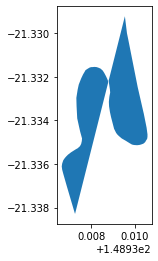

In [26]:
df = gpd.GeoDataFrame(columns=['geometry'])
df = df.append({'geometry': (Polygon(zone_coords))}, ignore_index=True)
df.plot()
plt.show()

## BOM Data

The BOM provides JSON API links to extract the latest weather data from selected weather stations.

Below is an example for the Canberra weather station:

In [27]:
url = 'http://www.bom.gov.au/fwo/IDN60903/IDN60903.94926.json' # Canberra weather station
r = get_data(url)
r['observations'].keys()

dict_keys(['notice', 'header', 'data'])

To get the latest weather, we access the first row of the `data` key. Below, we can see that BOM provides a series of variables from which CAS29 can extract a subset that are most relevant to a cyclist:

In [28]:
r['observations']['data'][0]

{'sort_order': 0,
 'wmo': 94926,
 'name': 'Canberra',
 'history_product': 'IDN60903',
 'local_date_time': '08/01:00pm',
 'local_date_time_full': '20190908130000',
 'aifstime_utc': '20190908030000',
 'lat': -35.3,
 'lon': 149.2,
 'apparent_t': 3.8,
 'cloud': '-',
 'cloud_base_m': None,
 'cloud_oktas': None,
 'cloud_type_id': None,
 'cloud_type': '-',
 'delta_t': 5.2,
 'gust_kmh': 43,
 'gust_kt': 23,
 'air_temp': 12.1,
 'dewpt': -0.1,
 'press': 1011.7,
 'press_qnh': 1011.6,
 'press_msl': 1011.7,
 'press_tend': '-',
 'rain_trace': '0.0',
 'rel_hum': 43,
 'sea_state': '-',
 'swell_dir_worded': '-',
 'swell_height': None,
 'swell_period': None,
 'vis_km': '10',
 'weather': '-',
 'wind_dir': 'WNW',
 'wind_spd_kmh': 33,
 'wind_spd_kt': 18}